### Answer 1.1
Search problems have the objective of finding a path from a starting point to a destination, usually through a network of interconnected nodes and dead ends. In this way, the maze solver is similar and can thus be seen as a search problem.
In the context of a search problem, the maze can be represented as a graph, where the nodes represent different locations in the maze (either a path or wall), and the edges connect adjacent nodes.

### Answer 1.2

The depth-first search algorithm is a traversal/search method on a graph or tree structure. It starts at a defined root node, and explores as far as possible along each branch before backtracking to find its goal. It has no guarantee to find the shortest solution first. 

Typical steps are: 

1. Start at a selected node in the graph
2. Mark the node as visited
3. For each adjacent node to the current node if not visited add to the stack 
4. pop node from stack and repeat steps 2 to 4 until all nodes visisted or goal found 


### Read me 
To execute a search algorithm run the python code and follow the menu.

To change the maze enter the filepath in the menu() function call at the bottom of the script. Be aware, when changing the name of the text file you should restart the kernal. Also ensure that you have clicked onto the code when trying to run.

In regard to the name of the scripts linking to questions. 

- dfs_with_nodes links to question 1.2

- astar_with_nodes links to question 1.3 

- dfs_with_matrix and astar_with_matrix link to further experimentation. 


#### Notes
- Sometimes the running of the Vlarge maze may take a long time but that is the jupyter environment and the actual time is shown in the elapsed time figure
- If data plots are not showing up, click run on the HTML text.<br>
- If you choose the option to output the maze to a .txt or .png then it will be called 'maze_output' (with its respective file type) and be located in the same directory as the jupyter notebook <br>
- path are printed in format (y,x)

#### References 
- The code for the visualize_path function was found online and is used simply to present the solution in a nice format. 


### Code


In [ ]:
import time
import itertools
from queue import PriorityQueue

#These imports are required for the .png output 
import sys
!{sys.executable} -m pip install pillow
from PIL import Image, ImageDraw

class Node:
    """
    A class to represent a node

    Attributes
    ----------
    position : (int, int)
        coordinates of this node 
    neighbours : []
        list of neighbour nodes
    visited : boolean
        If this node has been visited
    f : int
        total cost
    g : int 
        path cost of node
    h : int
        heuristic cost of the node

    Methods
    -------
    get_f:
        returns f.
    set_f:
        sets f
    get_g:
        returns g
    set_g:
        sets g
    set_h:
        sets h
    """
    def __init__(self, position, neighbours=[], visited=False):
        self.position = position
        self.neighbours = neighbours
        self.path = []
        self.visited = visited
        self.f = 20000
        self.g = 0
        self.h = 0
        
    def get_f(self):
        return self.f

    def set_f(self):
        self.f = self.g + self.h

    def get_g(self):
        return self.g

    def set_g(self, value):
        self.g = value

    def set_h(self, value):
        self.h = value

    
def resetNodes(nodes:type[Node]):
    """
    Resets all node objects to their original attributes
    """
    for node in nodes.values():
        node.visited = False
        node.path = []
        node.f = 20000
        node.g = 0
        node.h = 0
        
def file_to_maze(filename: str)->tuple[[[str]],(int,int), (int,int)]:
    """
    This function reads a file and returns the maze (in the form of a 2d array),
    the start state, and the goal state
    
    """
    maze = []
    with open(filename) as file:
        for line in file:
            data = line.split()
            maze.append(data)

    height = len(maze) - 1
    startState = (0, maze[0].index('-'))
    goalState = (height, maze[height].index('-'))

    return maze, startState, goalState


def print_to_textFile(maze: [[str]], solution: [(int, int)]) -> None:
    '''
    This function prints the maze with the route marked by 'O' to a .txt file
    '''
    for x in solution:
        maze[x[0]][x[1]] = 'O'
    
    with open('maze_output.txt', 'w') as f:
        for x in maze:
            f.write(" ")
            for y in x:
                f.write(y+" ")
            f.write("\n")
                
def visualize_path(mazes:[[str]], visited:[(int,int)], path:(int,int)):
    """
    This function outputs the maze to a .png file that shows the route and visited nodes.
    """
    # Define colors for drawing
    WALL_COLOR = (0, 0, 0)
    FREE_COLOR = (255, 255, 255)
    VISITED_COLOR = (159, 43, 104)
    PATH_COLOR = (0, 255, 0)
    
    # Convert maze list to an image
    img_width, img_height = len(mazes[0]), len(mazes)
    
    img = Image.new('RGB', (img_width, img_height))
    draw = ImageDraw.Draw(img)
    
    for y in range(img_height):
        for x in range(img_width):
            if mazes[y][x] == '#':
                draw.rectangle([(x, y), (x + 1, y+1)], fill=WALL_COLOR)
            else:
                draw.rectangle([(x, y), (x + 1, y+1)], fill=FREE_COLOR)

    # Mark visited cells in the image
    for cell in visited:
        draw.rectangle([(cell[1], cell[0]), (cell[1] + 0.5, cell[0] + 0.5)], fill=VISITED_COLOR)
        
    # Mark path cells in the image
    for cell in path:
        draw.rectangle([(cell[1], cell[0]), (cell[1] + 0.5, cell[0] + 0.5)], fill=PATH_COLOR)
        
    # Save the image to a file
    img.save('maze_output.png')    


def printStatistics(visited:[(int,int)], time:type[time], path:[(int,int)]):
    """
    This function prints the statistics passed in to the console
    """
    print("Nodes explored: ",len(visited))
    print("Elapsed time in seconds: ", time)
    print("Number of steps taken: ", len(path))


def find_neighbors(coords:(int, int), maze: [[str]])-> [(int, int)]:
    """
    This function returns a list of valid neighbouring nodes
        
    """
    col, row = coords
    visited = (
        discover_path((col - 1, row), maze),  # north
        discover_path((col + 1, row), maze),  # south
        discover_path((col, row - 1), maze),  # west
        discover_path((col, row + 1), maze)  # east
    )

    return [v for v in visited if isinstance(v, tuple)]


def discover_path(coords:(int,int), maze:[[str]]):
    """
    This function checks if an element at a given position within the maze 
    is a valid neighbouring path.
    
    returns:
        The position (col, row) of the node if it is valid otherwise returns false 
    """
    width, height = len(maze[0]), len(maze)
    col, row = coords
    
    if any((col < 0, col > height - 1, row < 0, row > width - 1)):
        return False
    elif maze[col][row] == '-':
        return col, row
    else:
        return False 
       
def create_nodes(maze:[[str]])->{(int,int):type[Node]}:
    """
    This function creates a dictionary of all path coordinates to a Node object that tracks information about that path elemt their node object
    """
    nodes = {}
    for col_idx, row in enumerate(maze):
        for row_idx, col in enumerate(row):
            coords = (col_idx, row_idx)
            if discover_path(coords, maze):
                new_node = Node(coords, find_neighbors(coords, maze))
                nodes.update({coords: new_node})

    return nodes
                    
#Answer to question 1.2 
    
def dfs_with_nodes(nodes:{(int,int): type[Node]}, startState:(int,int), goalState:(int,int)):
    """
    Implementation of depth first search using an adjacency List and Node object
    
    Returns: 
        visited -> (int,int)
        ElapsedTime -> time
        
        The current path with the startState added to the front
        
    """
    startTime = time.time()
    visited = set()
    stack = [nodes[startState]] #DFS uses a stack

    while not len(stack) == 0:
        current = stack.pop()

        if current.position == goalState:
            elapsedTime = time.time() - startTime #Calculating the change in time since start
            visited.add(current.position)
            
            return visited, elapsedTime, [startState] + current.path

        if not current.visited:
            current.visited = True
            visited.add(current.position)
            for coords in current.neighbours:  # Get neighbouring nodes
                next_path = nodes[coords] # Get node object from nodes dictionary
                next_path.path = current.path + [coords] # Set new nodes path to the current path plus its own coords
                stack.append(next_path)
        

#Answer to question 1.3
        
def astar_with_nodes(nodes:{(int,int): type[Node]}, startState:(int,int), goalState:(int,int)):
    '''
    Implementation of A* algorithm with adjacency List and Node object
    
    Returns: 
        visited -> (int,int)
        ElapsedTime -> time
        
        The current path with the startState added to the front
    '''
    startTime = time.time()
    PQ = PriorityQueue()
    counter = itertools.count()
    visited = set()
    
    PQ.put((0, 0, nodes[startState])) #A* uses a priority queue

    while PQ.not_empty:
        current = PQ.get()[2]

        if current.position == goalState:
            elapsedTime = time.time() - startTime
            visited.add(current.position)
            return visited, elapsedTime, [startState] + current.path

        if not current.visited:
            current.visited = True
            visited.add(current.position)
            for coords in current.neighbours:
                next_path = nodes[coords]
                temporary_g = current.g + 1 
                h = calculate_manhattan_distance(next_path.position, goalState) #Calculate heuristic 
                temporary_f = h + temporary_g # Calculate f value
                if temporary_f < next_path.get_f(): # Check if temporary f is less than its existing f 
                    next_path.set_g(temporary_g)
                    next_path.set_h(h)
                    next_path.set_f()
                    next_path.path = current.path + [coords]
                    count = next(counter) # Counter is used to deal with the case of duplicate priorities
                    PQ.put((next_path.get_f(), count, next_path))


                
def calculate_manhattan_distance(current: (int, int), goal: (int, int)) -> int:
    """
    Calculates an admissible heuristic distance between two points
    """
    return abs(current[1] - goal[1]) + abs(current[0] - goal[0])

def squared_euclideancurrent(current:(int, int), goal: (int, int)) -> int:
    """
    Calculates a heuristic distance between two points
    """
    return (current[0] - goal[0]) ** 2 + (current[1] - goal[1]) ** 2               
                    
              
                    
                    
def get_adjacent_paths(maze: [[str]], node: (int, int)) -> [(int, int)]:
    """
    Returns a list of the coordinates of path nodes ('-') that are adjacent to the node passed in as
    a parameter to the function 
    
    Returns: 
        visited -> (int,int)
        ElapsedTime -> time
        
        The current path with the startState added to the front
    """
    width = len(maze[0])
    height = len(maze)

    x_cord = node[1]
    y_cord = node[0]

    paths = []

    if (y_cord - 1) >= 0:  # North
        if maze[y_cord - 1][x_cord] == '-':
            paths.append(((y_cord - 1, x_cord), [], 0))

    if (y_cord + 1) < height:  # South
        if maze[y_cord + 1][x_cord] == '-':
            paths.append(((y_cord + 1, x_cord), [], 0))

    if (x_cord - 1) >= 0:  # West
        if maze[y_cord][x_cord - 1] == '-':
            paths.append(((y_cord, x_cord - 1), [], 0))

    if (x_cord + 1) < width:  # East
        if maze[y_cord][x_cord + 1] == '-':
            paths.append(((y_cord, x_cord + 1), [], 0))

    return paths


def dfs_with_matrix(maze: [[str]], startState: (int, int), goalState: (int, int)):
    """
    Depth first search with maze 2d array only
    
    Returns: 
        visited -> (int,int)
        ElapsedTime -> time
        
        The current path with the startState added to the front
    
    """
    startTime = time.time()
    stack = []
    visited = set()
    stack.append((startState, [])) # Stack contains the coordinates and path to coordinates in a tuple 

    while not len(stack) == 0:  
        current, currentPath = stack.pop() 

        if current == goalState:
            elapsedTime = time.time() - startTime
            visited.add(current)
            return visited, elapsedTime, [startState] + currentPath

        if current not in visited:
            visited.add(current)
            for path in get_adjacent_paths(maze, current):
                stack.append((path[0], currentPath + [path[0]]))



def astar_with_matrix(maze: [[str]], startState: (int, int), goalState: (int, int)):
    '''
    Implementation of A* algorithm with maze 2d array only 
    
    Returns: 
        visited -> (int,int)
        ElapsedTime -> time
        
        The current path with the startState added to the front
    '''
    startTime = time.time()
    counter = itertools.count()
    PQ = PriorityQueue()
    visited = set()

    PQ.put((0, 0, (startState, [], 0)))

    while PQ.not_empty:
        current, currentPath, costSoFar = PQ.get()[2]

        if current == goalState:
            elapsedTime = time.time() - startTime
            visited.add(current)
            return visited, elapsedTime, [startState] + currentPath

        if current not in visited:
            visited.add(current)
            for cord, path, cost in get_adjacent_paths(maze, current):
                count = next(counter)
                new_cost = costSoFar + cost + 1
                temp_f = new_cost + calculate_manhattan_distance(cord, goalState)
                PQ.put((temp_f, count, (cord, currentPath + [cord], new_cost)))
                
    
def menu(filename: str):
    """
    Function that displays a menu and starts maze searching
    """
    
    maze, startState, goalState = file_to_maze(filename)  # Retrieve the maze, startState and goalState
    print("Welcome to path solver \n")
    print("......................\n")


    out_type = 0
    while out_type < 1 or out_type > 4:
        print("Please select how you would like your mazes output\n")
        out_type = int(input("  1.Path to console\n  2.Solved maze to textfile\n  3.Solved maze to detailed png in directory\n  4.No output\n"))
    
    algo = 0
    while algo < 1 or algo > 4:
        print("Please now select your algorithm !\n")
        algo = int(input("  1.DFS_node\n  2.A*_node\n  3.DFS_matrix\n  4.A*_matrix"))
    
    match int(algo):
        case 1:
            print("\nCreating Nodes...(this may take a few seconds)\n")
            nodes = create_nodes(maze)  
            print("\nDFS_node selected\n")
            visited, time ,path = dfs_with_nodes(nodes, startState, goalState)
        
            
        case 2:
            print("\nCreating Nodes...(this may take a few seconds)\n")
            nodes = create_nodes(maze)  
            print("\nA*_node selected")
            visited, time ,path = astar_with_nodes(nodes, startState, goalState)
          
        
        case 3:
            print("\nDFS_matrix selected")
            visited, time, path = dfs_with_matrix(maze, startState, goalState)
        
                
        case 4:
            print("\nA*_matrix selected")
            visited, time, path = astar_with_matrix(maze, startState, goalState)
            
  
    printStatistics(visited, time, path)
    
    match int(out_type):
        case 1:
            print(path)
        case 2:
            print_to_textFile(maze,path)
        case 3:
            visualize_path(maze, visited, path)

            
    print("Thank you for using maze solver")
        
        
                
menu("Mazes/maze-large.txt") #Enter maze location here

Welcome to path solver 

......................

Please select how you would like your mazes output



### Statistics for depth-Search

#### 'maze-Easy.txt'

Nodes Explored = 36 <br>
Elapsed time in seconds = 0.0 <br>
Number of steps taken = 27 <br>

#### 'maze-Medium.txt'

Nodes Explored = 888 <br>
Elapsed time in seconds =  0.0054988861083984375 <br>
Number of steps taken = 469 <br>

#### 'maze-large.txt'

Nodes Explored = 73982 <br>
Elapsed time in seconds =  0.5604982376098633 <br>
Number of steps taken = 1050 <br>

#### 'maze-Vlarge.txt'

Nodes explored =  389073 <br>
Elapsed time in seconds =  34.26656532287598 <br>
Number of steps taken =  3737 <br>


### Discussion

As the results show above, the algorithm performed much quicker on smaller mazes. There is a positive correlation between the size of the graph, and an increase in the number or steps, elapsed time and nodes explored. 

However, depending on the order in which nodes are added to the stack, for example, adding the east node before the west node, this can drastically change the statistics of the depth first search.

The statistics I recieved above are from nodes added in the order of north, south, west, east. To test the impact of the order in which they are added I changed my functions to add them in the order of east,west,south, north and these are the results obtained. 

### Statistics for depth-Search with alternative node addition

#### 'maze-Easy.txt'

Nodes explored =  82 <br>
Elapsed time in seconds =  0.0004994869232177734 <br>
Number of steps taken = 27 <br>

#### 'maze-medium.txt'

Nodes explored =  6876 <br>
Elapsed time in seconds =  0.027497291564941406 <br>
Number of steps taken = 509 <br>

#### 'maze-large.txt'

Nodes explored = 13580 <br>
Elapsed time in seconds =  0.08449935913085938 <br>
Number of steps taken = 1120 <br>

#### 'maze-vlarge.txt'

Nodes explored = 620707 <br>
Elapsed time in seconds =  95.87080216407776 <br>
Number of steps taken =  5725 <br>


As shown above, changing the order in which nodes are appended has a huge impact on the results obtained especially in the larger maze. This is because the order in which paths are traversed changes. 

Comparing these changes in the large maze, there was an increase of 180% in the elapsed time from 38 seconds to 91 seconds. Moreover, there was also an increase in nodes explored by 59% from 389073 to 620707, and the final path discovered was 53% longer. If I were to consider optimizing this implementation of DFS on mazes, one of the places to start would be the ordering of the nodes. However, there may be no impact if the mazes are generated completely randomly with no human bias to the structure or design.


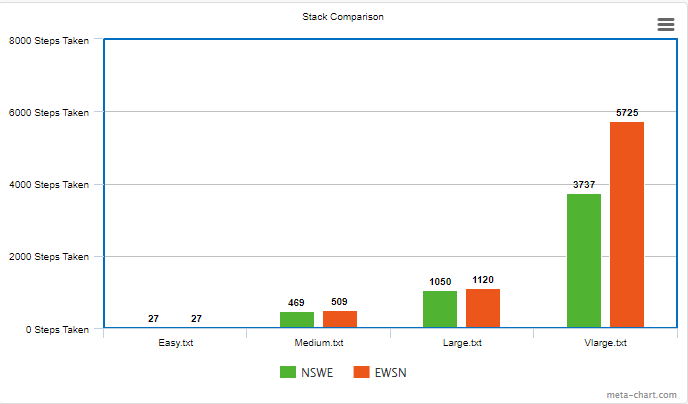

As shown by the graph, adding the nodes in order of north, south, west, east (NSWE) resulted in a shorter path found for each maze.txt file when compared to adding them in order of east, west, south, north (EWSN). Whether this holds for every maze would require more testing. It is also likely another ordering of stack addition could have a greater impact on the statistics of the depth first search. For example, south, west, north, east could result in a faster execution time or shorter path found.  

## Answer 1.3

An alternative algorithm to solve the maze would be the A* search algorithm which is considered and extension of Dijkstras algorithm, but with the improvement of using a heuristic. 
To justify the use of this algorithm, I believe it will scale down the exploration of nodes to the direction of the goal, decreasing the elapsed time and providing an optimal path if the heuristic used is admissible. However, the number of nodes explored may increase as it attempts to find the optimal path.  


### Statistics for A*

#### 'maze-Easy.txt'

Nodes Explored = 57  <br>
Elapsed time in seconds = 0.0009 <br>
Number of steps taken = 27 <br>

#### 'maze-Medium.txt'

Nodes Explored = 2053 <br>
Elapsed time in seconds = 0.023494720458984375 <br>
Number of steps taken = 321 <br>

#### 'maze-large.txt'

Nodes Explored = 41925 <br>
Elapsed time in seconds = 0.5789 <br>
Number of steps taken = 974 <br>

#### 'maze-Vlarge.txt'

Nodes Explored = 273890 <br>
Elapsed time in seconds = 9.719 <br>
Number of steps taken = 3691 <br>


### Discussion

The most notable changes are those with 'maze-Vlarge.txt' and therefore it will be the center of our discussion.

A* performs much quicker (almost 4x) on this large dataset with the reason for this improvement being the use of a priority queue and heuristic to encourage node exploration in the direction of the goal. On the otherhand, depth-first search does not have this same encouragement resulting in the exploration of nodes in various directions according to the order they are added to the stack.

However, as seen in 'maze-Medium.txt' the depth first search can sometimes discover a path quickly with a bit of luck; resulting in very few nodes explored. Although, the probability of this happening decreases as the size of the search problem increases and that is why it is not very effective for the very large maze.

Another way in which the A* algorithm performed better was in its path discovery. The use of the manhattann distance (which is admissible) as a heuristic, allowed A* to find the optimal path through the maze unlike the path discovered with depth first search. 

In testing of my A* algorithm I also considered using the squared euclidian distance as a heuristic however as it is not admissible (and overestimates) there is no guarantee it will find the optimal path; narrowing my choice the manhattann distance.

Below is a plot demonstrating the difference in steps taken between DFS (NSWE) and the A* algorithm.

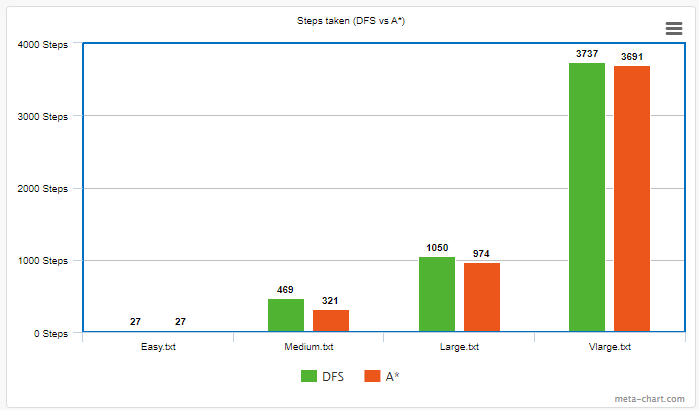


### Statistics for A* search with alternative node addition

After collecting the results of DFS with alternative node addition I repeated the same test on the A* algorithm. Unsurprisingly, it had no impact as the priority queue data structure ordered the nodes accordingly when they were added. 


### Further experimentation

To further experiment I wanted to determine the impact that data structures had on the algorithm. I wanted to understand if using node objects with their neighbours precalculated had a substantial impact on the statistics of my depth first search and A* search. Therefore, I implemented both algorithms only using the maze array and calculating neighbours at runtime to determine the impact.

As seen in 'astar_search_with_matrix' and 'dfs_with_matrix'.

### Experiment statistics 

#### 'maze-Easy.txt'

A*Matrix: <br> <br>
Visited nodes :  57 <br>
Length of path = 27 <br>
Elapsed time in seconds =  0.0014998912811279297 <br>
 <br>
DepthFirstSearchM:  <br> <br>
Visited nodes :  36 <br>
Length of path = 27 <br>
Elapsed time in seconds =  0.0 <br>
 <br>
#### 'maze-Medium.txt'

A*Matrix:  <br> <br>
Visited nodes :  2053 <br>
Length of path = 321 <br>
Elapsed time in seconds =  0.0370023250579834 <br>

DepthFirstSearchM:  <br> <br>
Visited nodes :  888 <br>
Length of path = 469 <br>
Elapsed time in seconds =  0.0049974918365478516 <br>
 <br>
#### 'maze-Large.txt'

A*Matrix:  <br> <br>
Visited nodes :  41925 <br>
Length of path = 974 <br>
Elapsed time in seconds =  1.2105000019073486 <br>

DepthFirstSearchM:  <br> <br>
Visited nodes :  73982 <br>
Length of path = 1050 <br>
Elapsed time in seconds =  0.6620004177093506 <br>
 <br>
#### 'maze-VLarge.txt'

A*Matrix:  <br> <br>
Visited nodes :  273890 <br>
Length of path = 3691 <br>
Elapsed time in seconds =  22.660500526428223 <br>

DepthFirstSearchM:  <br> <br>
Visited nodes :  389073 <br>
Length of path = 3737 <br>
Elapsed time in seconds =  22.876997709274292 <br>

 <br>

### Discussion 

By removing the node objects, the overhead of running these program was removed as creating the data structure no longer occured. This could be seen as a benefit in the terms of simplicity of the algorithm and execution time if you were to include the setup of the datastructure in the calculation of execution time (which i did not).  

To control the tests I had to ensure both algorithms were adding the nodes in the same order or this would affect the results. To achieve this I compared the number of nodes visited and and path lengths discovered and ensured that nodes were added to the stack in the same order (for DFS).

##### DFS vs Matrix DFS

The differences between these implementions appeared in the execution time, where the matrix implementation executed faster on the Vlarge maze by 11.3895 seconds. This time did not include the additional overhead of creating the adjacency list. If it had then the matrix implementation would have executed and an estimated 20 seconds faster.

The results suggest that the use of an adjacency list and node object did not improve the performance of the depth-first search and instead hindered it.

##### A* vs Matrix A*

On the Vlarge maze, the matrix implementation showed the greatest difference running for an extra 12.942 seconds in comparison to the original.

This change contrasts to the faster execution found with regards to the matrix implementation of DFS. I believe It can be explained as the A* algorithm is more complex with calculations for ordering the queue and calculating the cost of path. By also calculating the neighbours at runtime in the matrix implementation It may put further load on the CPU increasing the execution time. However, the increase in execution time could also be caused due to the large amount of data passed within the priority queue. 

##### Matrix A* vs Matrix DFS

In the experiment both algorithms executed in a similar time frame which was unexpected as I had assumed the A* algorithm to find a path faster than DFS. However, I believe that because the A* algorithm finds an optimal path and is not using effective data structures to do so the DFS can achieve a sub optimal result in the same time frame. 

##### Conclusion

The conclusion to this test is that the choice of data structure can have a great impact on the runtime of search algorithms. Moreover, if I were to do futher experimentations I would make use of O(1) accesss time datastructures such as dictionaries to keep track of nodes as there would be further performance gains in the execution speed of the algorithm; at a cost to the memory complexity potentially.
